In [1]:
import os
from glob import glob

import torch
import numpy as np

import matplotlib.pyplot as plt

from io import BytesIO
from PIL import Image
from tqdm.auto import tqdm
from IPython import display

### Functions

In [2]:
# N-dimentional Linear Interpolation
def nlerp(tensor: torch.Tensor, output_shape=None, scale_factor=None):
    device = tensor.device
    
    input_shape = torch.tensor(tensor.shape)
    if scale_factor is not None:
        output_shape = (input_shape * scale_factor).long()
    
    if output_shape is None:
        raise ValueError('output_shape or scale_factor must be provided.')
    
    ndim = tensor.ndim
    if ndim != output_shape.size(0):
        raise ValueError('The output dimension cannot be changed.')
    
    dimensions = list(range(ndim))
    dimensions = dimensions[1:] + dimensions[:1]
    t_unsqueeze = [1 for _ in range(ndim)]
    t_unsqueeze[0] = -1
    output = tensor
    for in_size, out_size in zip(input_shape, output_shape):
        indices = torch.linspace(0, in_size - 1, out_size).to(device)
        indices_flr = indices.floor().long()
        indices_cel = indices.ceil().long()
        indices_t = (indices - indices.floor()).view(*t_unsqueeze)
        indices_t_ = 1 - indices_t
        output = output[indices_flr] * indices_t_ + output[indices_cel] * indices_t
        output = output.permute(*dimensions)
        
    return output

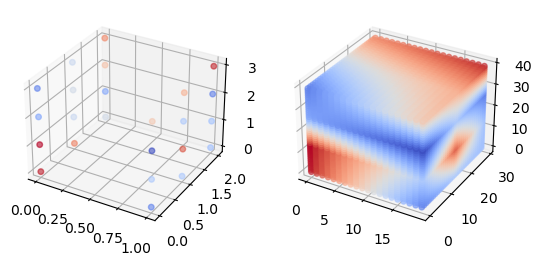

In [3]:
# 3D Voxel Plotting
def get_index_tensors(tensor: torch.Tensor):
    shape = tensor.shape
    ndim = tensor.ndim
    for i, size in enumerate(shape):
        unsqueeze_shape = np.ones(ndim, dtype=np.int32)
        unsqueeze_shape[i] = -1
        
        idx = torch.arange(size).view(*unsqueeze_shape)
        idx = idx.expand(*shape)
        yield idx.flatten()
        
def plot_3tensor(tensor: torch.Tensor, ax=None, cmap=None, s=16, alpha=0.6, marker=None):
    if ax is None:
        ax = plt.axes(projection='3d')
        
    x, y, z = get_index_tensors(tensor)
    c = tensor.flatten()
    return ax.scatter(x, y, z, c=c, s=s, cmap=cmap, marker=marker, alpha=alpha)
    

t1 = torch.randn(2, 3, 4)
t2 = nlerp(t1, scale_factor=10)
plot_3tensor(t1, ax=plt.subplot(121, projection='3d'), cmap='coolwarm')
plot_3tensor(t2, ax=plt.subplot(122, projection='3d'), cmap='coolwarm')
plt.show()

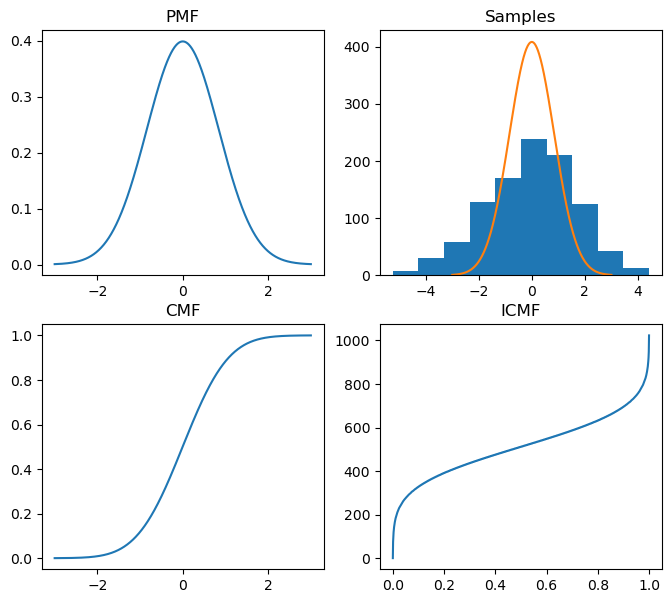

In [4]:
def get_icmf_1d(pmf: torch.Tensor):
    cmf = pmf.cumsum(dim=0) / pmf.sum()
    return lambda x: torch.searchsorted(cmf, x)

plt.figure(figsize=(8, 7))

std = 1.0
domain = 3
n_samples = 1024

x = torch.linspace(-domain, domain, n_samples)
var2 = std * std * 2.0
gaussian_pmf = np.power(var2 * np.pi, -0.5) * torch.exp(-(x * x) / np.sqrt(var2))
plt.subplot(221)
plt.title('PMF')
plt.plot(x, gaussian_pmf)

cmf = gaussian_pmf.cumsum(dim=0) / gaussian_pmf.sum()
plt.subplot(223)
plt.title('CMF')
plt.plot(x, cmf)

f_icmf = get_icmf_1d(gaussian_pmf)
icmf = f_icmf(torch.linspace(0, 1, n_samples))
plt.subplot(224)
plt.title('ICMF')
plt.plot((x + domain) / (domain * 2.0), icmf)

# samples = f_icmf(torch.linspace(0, 1, n_samples))
samples = f_icmf(torch.rand(n_samples))
samples = (samples / len(cmf) * 2 - 1) * (domain * 2.0)
plt.subplot(222)
plt.title('Samples')
plt.hist(samples)
plt.plot(x, gaussian_pmf * n_samples * std)

plt.show()

### Tuning

In [5]:
dirnames = sorted(glob('./log/imagenet1k_resnet50/lr_beta_gamma/normed/*'))
alpha, beta, gamma = [], [], []
fr = []
for dn in dirnames:
    tag = dn.split(os.sep)[-1].split('_')
    a, b, g = tuple(5 + int(t) for t in tag)
    
    ckpt_filename = os.path.join(dn, 'ckpt.pth')
    ckpt = torch.load(ckpt_filename)
    
    alpha.append(a)
    beta.append(b)
    gamma.append(g)
    fr.append(ckpt['fr'])
    
    with open('temp/out.txt', 'a+') as file:
        print(a, b, g, ckpt['fr'], file=file)

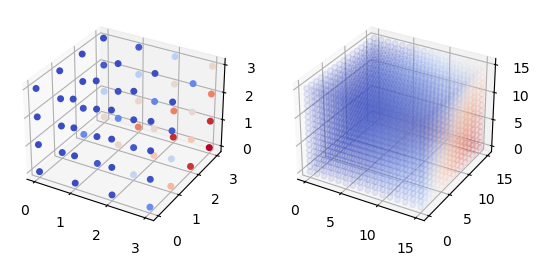

In [6]:
src_cube = torch.zeros(4, 4, 4)
src_cube[torch.tensor(alpha).long() - 1,
         torch.tensor(beta).long() - 1,
         torch.tensor(gamma).long() - 1] = torch.tensor(fr)
tar_cube = nlerp(src_cube, scale_factor=4)

plot_3tensor(src_cube, cmap='coolwarm', alpha=1.0, ax=plt.subplot(121, projection='3d'))
plot_3tensor(tar_cube, cmap='coolwarm', alpha=0.1, ax=plt.subplot(122, projection='3d'))
plt.show()


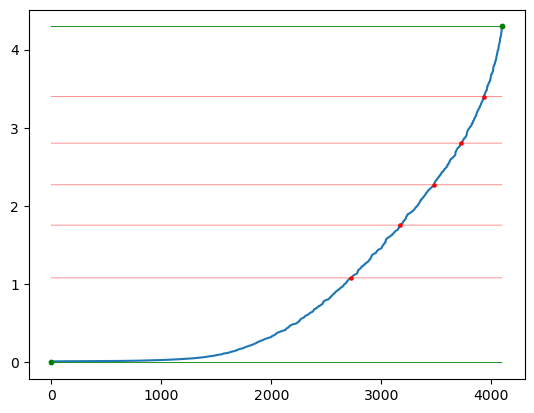

In [7]:
num_steps = 5
span_size = 0.1

cube_ascn = tar_cube.flatten().sort().values
icdf = get_icmf_1d(cube_ascn)

sample_space = torch.linspace(0, 1, num_steps + 2)[1:-1]

thresholds_x = icdf(sample_space)
thresholds = cube_ascn[thresholds_x]

plt.plot(cube_ascn, zorder=0)
for i, t in zip(thresholds_x, thresholds):
    plt.scatter([i], [t], c='red', s=5)
    plt.plot(torch.ones_like(cube_ascn) * t, c='red', linewidth=0.3)
for i, t in zip((0, len(cube_ascn)), (0, cube_ascn[-1])):
    plt.scatter([i], [t], c='green', s=10)
    plt.plot(torch.ones_like(cube_ascn) * t, c='green', linewidth=0.6)
plt.show()

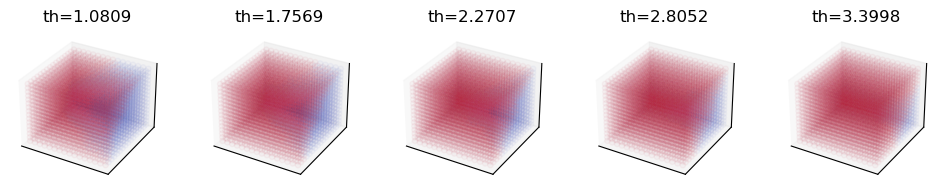

In [8]:
plt.figure(figsize=(12, 2))
for i, th in enumerate(thresholds, start=1):
    ax = plt.subplot(1, 5, i, projection='3d')
    new_cube = tar_cube <= th
    plt.title(f'{th=:.4f}')
    plot_3tensor(new_cube, ax=ax, alpha=0.03, cmap='coolwarm')
    ax.set_xticks([]); ax.set_yticks([]); ax.set_zticks([])

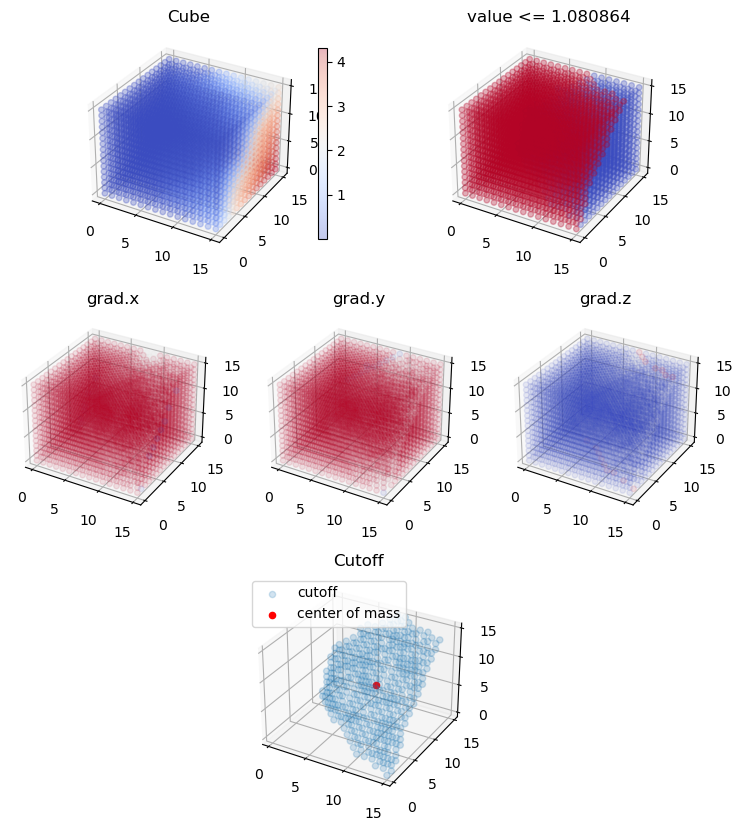

In [9]:
threshold = thresholds[0]
cube = (tar_cube <= threshold).float()
grads = torch.stack(torch.gradient(cube), dim=0)
grad = torch.any(grads, dim=0)

plt.figure(figsize=(9, 10))
ax = plt.subplot(321, projection='3d')
plt.title('Cube')
scat = plot_3tensor(tar_cube, ax=ax, cmap='coolwarm', alpha=0.3)
plt.colorbar(scat, fraction=0.03)
ax = plt.subplot(322, projection='3d')
plt.title(f'value <= {threshold:4f}')
plot_3tensor(cube, ax=ax, cmap='coolwarm', alpha=0.3)

for i, (g, tag) in enumerate(zip(grads, 'xyz'), start=4):
    ax = plt.subplot(3, 3, i, projection='3d')
    plt.title(f'grad.{tag}')
    plot_3tensor(g, ax=ax, cmap='coolwarm', alpha=0.1)

ax = plt.subplot(313, projection='3d')
plt.title('Cutoff')
icdf = grad.to_sparse().indices()
mass_center = icdf.float().mean(dim=1, keepdim=True)
grad = grad[icdf[0], icdf[1], icdf[2]]
ax.scatter(*icdf, alpha=0.2)
ax.scatter(*mass_center, color='red', alpha=1.0)
ax.set_xlim((-0.5, 15.5))
ax.set_ylim((-0.5, 15.5))
ax.set_zlim((-0.5, 15.5))
plt.legend(['cutoff', 'center of mass'])
plt.show()

/tmp/ipykernel_29484/2263098139.py:27: UserWarning: torch.symeig is deprecated in favor of torch.linalg.eigh and will be removed in a future PyTorch release.
The default behavior has changed from using the upper triangular portion of the matrix by default to using the lower triangular portion.
L, _ = torch.symeig(A, upper=upper)
should be replaced with
L = torch.linalg.eigvalsh(A, UPLO='U' if upper else 'L')
and
L, V = torch.symeig(A, eigenvectors=True)
should be replaced with
L, V = torch.linalg.eigh(A, UPLO='U' if upper else 'L') (Triggered internally at /opt/conda/conda-bld/pytorch_1666642975993/work/aten/src/ATen/native/BatchLinearAlgebra.cpp:2794.)
  eig_values, eig_vecs = torch.symeig(cov_matrix, eigenvectors=True)


  0%|          | 0/90 [00:00<?, ?it/s]

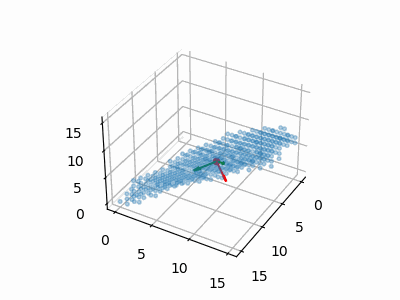

In [10]:
def find_perpendicular(vectors: torch.Tensor, threshold: float=1.0E-4, max_iters: int=None):
    perp = torch.ones(1, vectors.size(0), requires_grad=True)
    loss, iters = torch.inf, 0
    while True:
        if max_iters and iters >= max_iters:
            break
        loss = torch.mm(perp, vectors).square().mean()
        if loss < threshold:
            break
        loss.backward()
        perp = perp - perp.grad
        perp /= perp.norm(dim=1, keepdim=True)
        perp = perp.detach().requires_grad_(True)
    return perp.detach().requires_grad_(False).squeeze()

def calc_normal(pc, acquire_eig_vecs=True):
    dim = pc.size(0)
    if dim < 3:
        raise RuntimeError('IMPOSSIBLE')
    
    pointcloud = pc.float()
    pointcloud -= pointcloud.min(dim=1, keepdim=True).values
    pointcloud /= pointcloud.max()

    centered = pointcloud - torch.mean(pointcloud, dim=1, keepdim=True)
    cov_matrix = torch.mm(centered, centered.t()) / (pointcloud.shape[1] - 1)
    eig_values, eig_vecs = torch.symeig(cov_matrix, eigenvectors=True)

    sorted_idx = torch.argsort(eig_values, descending=True)
    eig_vecs = eig_vecs[:, sorted_idx[:pc.size(0)-1]]
    
    if dim == 3:
        norm_vec = torch.cross(*eig_vecs.T)
    else:
        norm_vec = find_perpendicular(eig_vecs)

    if acquire_eig_vecs:
        return norm_vec, eig_vecs
    else:
        return norm_vec

norm_vec, eig_vecs = calc_normal(icdf)
quv_init = mass_center.expand_as(eig_vecs)

plt.figure(figsize=(4, 3))
ax = plt.axes(projection='3d')
ax.scatter(*icdf, alpha=0.3, s=7)
ax.scatter(*mass_center, color='red', alpha=1.0)
ax.quiver(*quv_init, *eig_vecs * 3, color='green')
ax.quiver(*mass_center, *norm_vec * 3, color='red')

frames = []
anchor = np.array((20, 30), dtype=np.float32)
offset_size = 15.0
for theta in tqdm(np.linspace(0, np.pi * 2, 90)):
    offset = np.array((np.cos(theta), np.sin(theta))) * offset_size
    ax.view_init(*(anchor + offset))
    
    buf = BytesIO()
    plt.savefig(buf)
    
    frame = Image.open(buf)
    frames.append(frame)
plt.close()

buf = BytesIO()
frames[0].save(buf, format='gif', save_all=True, append_images=frames[1:], optimize=False, duration=40, loop=0)
display.display(display.Image(data=buf.getvalue(), format='gif'))

  0%|          | 0/90 [00:00<?, ?it/s]

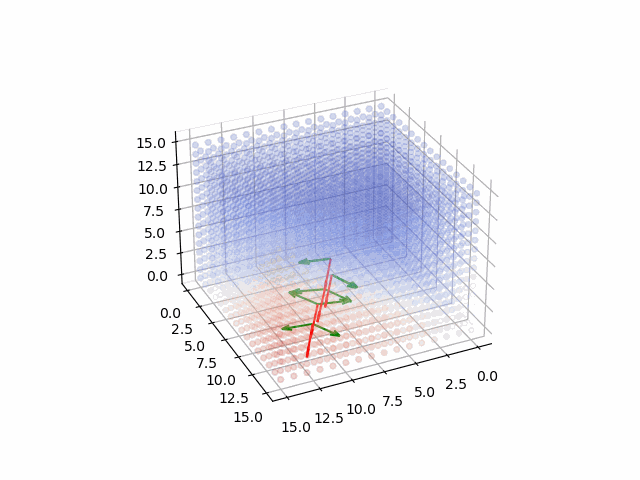

In [11]:
# Find normal vectors
centers, normals = [], []
eig_vecs = []
for threshold in thresholds:
    cube = (tar_cube <= threshold).float()
    grads = torch.stack(torch.gradient(cube), dim=0)
    grad = torch.any(grads, dim=0)
    pointcloud = grad.to_sparse().indices()
    
    center = pointcloud.float().mean(dim=1)
    normal, eig_vec = calc_normal(pointcloud)

    centers.append(center)
    normals.append(normal)
    eig_vecs.append(eig_vec)
centers, normals = torch.stack(centers, dim=1), torch.stack(normals, dim=1)
eig_vecs = torch.cat(eig_vecs, dim=1)
eig_centers = centers[:, None].expand(3, 2, len(thresholds)).reshape_as(eig_vecs)

# Align the direction
global_good = (tar_cube == tar_cube.max()).nonzero() - (tar_cube == tar_cube.min()).nonzero()
global_good = global_good / global_good.float().norm()
normals = normals * torch.sign(torch.mm(global_good, normals))

# Plot
quiv_mag = 3.0
ax = plt.axes(projection='3d')
plot_3tensor(tar_cube, ax=ax, cmap='coolwarm', alpha=0.15)
ax.quiver(*eig_centers, *(eig_vecs * quiv_mag), color='green')
ax.quiver(*centers, *(normals * quiv_mag), color='red')

frames = []
anchor = np.array([30, 45])
for theta in tqdm(np.linspace(np.pi * 2.0, 0, 90)):
    view = anchor + np.array([np.sin(theta), np.cos(theta)]) * 20.0
    
    ax.view_init(*view)
    buf = BytesIO()
    plt.savefig(buf)
    frames.append(Image.open(buf))
plt.close()

buf = BytesIO()
frames[0].save(buf, format='gif', save_all=True, append_images=frames[1:], optimize=False, duration=40, loop=0)
display.display(display.Image(data=buf.getvalue(), format='gif'))

CENTER
tensor([[ 8.4472,  9.1461,  6.6045],
        [ 8.9948, 10.5143,  5.9974],
        [ 9.8378, 11.1554,  5.1622],
        [10.7397, 11.8995,  4.3699],
        [11.5970, 12.8955,  3.2537]])

CENTER DIST
tensor([[1.5939],
        [1.3488],
        [1.4124],
        [1.7241]])

NORMAL
tensor([[ 0.4942,  0.7118, -0.4991],
        [ 0.5029,  0.7005, -0.5064],
        [ 0.5129,  0.6884, -0.5129],
        [ 0.5048,  0.7024, -0.5019],
        [ 0.4798,  0.7323, -0.4832]])


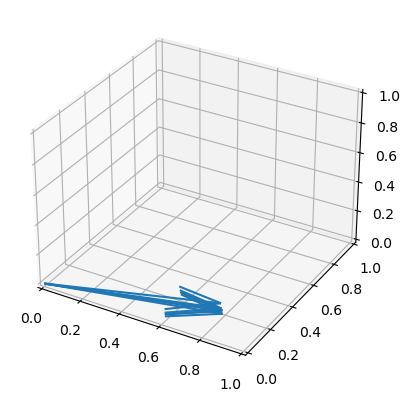

In [14]:
ax = plt.axes(projection='3d')
ax.quiver(*torch.zeros_like(normals), *normals)
for c in 'xyz':
    eval(f'ax.set_{c}lim')(0, 1)

print('CENTER')
print(centers.T, sep='\n')
print()

print('CENTER DIST')
roll_centers = centers.roll(shifts=1, dims=1)
print(torch.norm(roll_centers - centers, dim=0)[None, 1:].T)
print()

print('NORMAL')
print(normals.T)

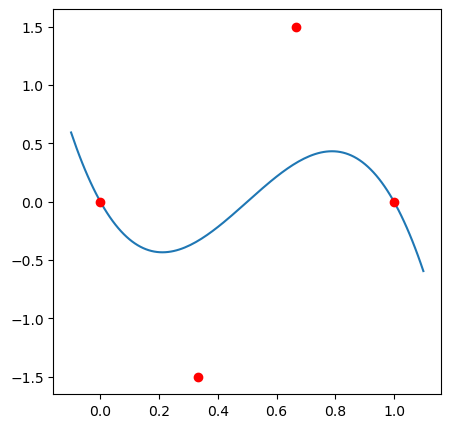

In [13]:
make = lambda *t: torch.tensor(t)

p0 = make(0, 0)
p1 = make(1, 0)
a = make(0.333, -1.5)
b = make(0.667, 1.5)
anchors = torch.stack([p0, a, b, p1], dim=0)

pad = 0.1
#region
t = torch.linspace(0 - pad, 1 + pad, 128)
coef = torch.stack([
    (1 - t) ** 3,
    3 * t * (1 - t) ** 2,
    3 * t ** 2 * (1 - t),
    t ** 3,
], dim=0)

curve = torch.mm(anchors.T, coef)

plt.figure(figsize=(5, 5))
plt.scatter(*anchors.T, c='red')
plt.plot(*curve, zorder=0)
plt.show()
#endregion